In [1]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader,WeightedRandomSampler,SubsetRandomSampler, Subset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from collections import Counter, namedtuple
import numpy as np
import torch
import copy

import warnings
from typing import Any, Callable, Optional
import torch.nn as nn
from torch import Tensor
from torchvision.models import GoogLeNet_Weights
import torch.nn.functional as F

### Apply different transforms to augment the dataset

The transforms are done online when called by the DataLoader, so every time its called to generate a batch the transforms are applied randomly,
which allows the model to see the same image differently almost every epoch

In [2]:
# 1. Setup Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
train_transforms = transforms.Compose([
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5, fill=128), #augmentation
    transforms.RandomRotation(10), #augmentation
    transforms.RandomResizedCrop(size=(256, 256), scale=(0.5, 1.0), ratio=(0.75, 1.33)), #resizing is essential but cropping is augmentation
    transforms.RandomHorizontalFlip(0.5), #augmentation
    transforms.ColorJitter(brightness=0.1, contrast=0.1), #augmentation 
    transforms.ToTensor(), #essential
])
val_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

Read the data

In [4]:
#Read it twice because each one has different transforms
root = "/kaggle/input/nn-26-scene-style-classification/StyleClassificationIndoors/"
trainDataset = datasets.ImageFolder(root=root + 'StyleClassificationIndoors/train', transform=train_transforms)
valDataset   = datasets.ImageFolder(root=root + 'StyleClassificationIndoors/train', transform=val_transforms)

targets = trainDataset.targets
#split by index, not the actual data
train_idx, val_idx = train_test_split(
    np.arange(len(targets)), 
    test_size=0.2,           #80/20 split
    shuffle=True, 
    stratify=targets     #to keep the same distribution of classes in both sets
)

train_subset = Subset(trainDataset, train_idx)
val_subset   = Subset(valDataset, val_idx)


The boho and the minimalist classes are outliers in the terms of number of images. boho: 918, minimalist: 555

In [5]:
counter = Counter(trainDataset.targets)
for class_index, count in counter.most_common():
    class_name = trainDataset.classes[class_index]
    print(f"{class_name}: {count}")

boho: 918
eclectic: 809
modern: 809
farmhouse: 795
coastal: 794
mediterranean: 789
french-country: 788
contemporary: 782
asian: 779
southwestern: 772
tropical: 772
scandinavian: 768
craftsman: 764
industrial: 764
victorian: 759
shabby-chic-style: 746
minimalist: 555


Balance only the training dataset using a weighted random sampler

In [6]:
train_targets = np.array(targets)[train_idx] #get all the training targets

#calculate the weights
class_counts = np.bincount(train_targets)
class_weights = 1. / class_counts

#map each label to its weight
sample_weights = class_weights[train_targets] #this create an array of len(train_targets), and its like every we are indexing by the target label 
sample_weights = torch.from_numpy(sample_weights).double()

train_sampler = torch.utils.data.WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

In [7]:
train_loader = DataLoader(
    train_subset, 
    batch_size=32, 
    sampler=train_sampler,
    num_workers=4
)

val_loader = DataLoader(
    val_subset, 
    batch_size=32, 
    shuffle=False,        
    num_workers=4
)

In [8]:
print(f"Training on {len(train_subset)} images.")
print(f"Validating on {len(val_subset)} images.")

Training on 10530 images.
Validating on 2633 images.


### Visualize a batch

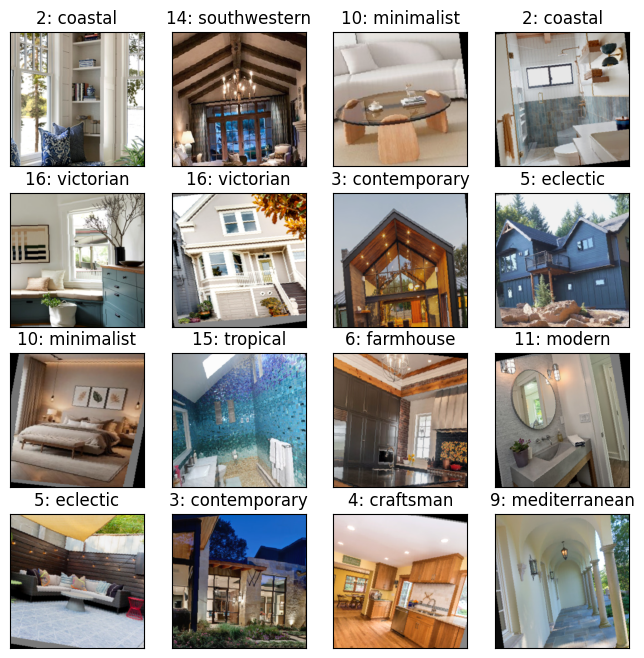

In [9]:
indoorStyleClasses = trainDataset.classes

data_iter = iter(train_loader)
images, labels = next(data_iter)

fig = plt.figure(figsize=(8, 8))

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    
    img_display = images[i].numpy().transpose((1, 2, 0))
    plt.imshow(img_display)
    idx = labels[i].item()
    real_name = indoorStyleClasses[idx]
    
    ax.set_title(f"{idx}: {real_name}")

plt.show()

In [10]:
class BasicConv2d(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, **kwargs: Any) -> None:
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001)

    def forward(self, x: Tensor) -> Tensor:
        x = self.conv(x)
        x = self.bn(x)
        return F.relu(x, inplace=True)


class Inception(nn.Module):
    def __init__(
        self,
        in_channels: int,
        ch1x1: int,
        ch3x3red: int,
        ch3x3: int,
        ch5x5red: int,
        ch5x5: int,
        pool_proj: int,
    ) -> None:
        super().__init__()
        conv_block = BasicConv2d
        self.branch1 = conv_block(in_channels, ch1x1, kernel_size=1)

        self.branch2 = nn.Sequential(
            conv_block(in_channels, ch3x3red, kernel_size=1),
            conv_block(ch3x3red, ch3x3, kernel_size=3, padding=1),
        )

        self.branch3 = nn.Sequential(
            conv_block(in_channels, ch5x5red, kernel_size=1),
            conv_block(ch5x5red, ch5x5, kernel_size=3, padding=1),
        )

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1, ceil_mode=True),
            conv_block(in_channels, pool_proj, kernel_size=1),
        )

    def _forward(self, x: Tensor) -> list[Tensor]:
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)

        outputs = [branch1, branch2, branch3, branch4]
        return outputs

    def forward(self, x: Tensor) -> Tensor:
        outputs = self._forward(x)
        return torch.cat(outputs, 1)


class InceptionAux(nn.Module):
    def __init__(
        self,
        in_channels: int,
        num_classes: int,
        dropout: float = 0.7,
    ) -> None:
        super().__init__()
        conv_block = BasicConv2d
        self.conv = conv_block(in_channels, 128, kernel_size=1)

        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, num_classes)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x: Tensor) -> Tensor:
        # aux1: N x 512 x 14 x 14, aux2: N x 528 x 14 x 14
        x = F.adaptive_avg_pool2d(x, (4, 4))
        # aux1: N x 512 x 4 x 4, aux2: N x 528 x 4 x 4
        x = self.conv(x)
        # N x 128 x 4 x 4
        x = torch.flatten(x, 1)
        # N x 2048
        x = F.relu(self.fc1(x), inplace=True)
        # N x 1024
        x = self.dropout(x)
        # N x 1024
        x = self.fc2(x)
        # N x 1000 (num_classes)

        return x


class GoogLeNet(nn.Module):
    def __init__(
        self,
        num_classes: int = 1000,
        aux_logits: bool = True,
        init_weights: Optional[bool] = True,
        dropout: float = 0.2,
        dropout_aux: float = 0.7,
    ) -> None:
        super().__init__()
        conv_block = BasicConv2d
        inception_block = Inception
        inception_aux_block = InceptionAux

        self.aux_logits = aux_logits
        
        self.conv1 = conv_block(3, 64, kernel_size=7, stride=2, padding=3)
        self.maxpool1 = nn.MaxPool2d(3, stride=1, ceil_mode=True)
        self.conv2 = conv_block(64, 64, kernel_size=1)
        self.conv3 = conv_block(64, 192, kernel_size=3, padding=1)
        self.maxpool2 = nn.MaxPool2d(3, stride=2, ceil_mode=True)

        self.inception3a = inception_block(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = inception_block(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(3, stride=2, ceil_mode=True)

        self.inception4a = inception_block(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = inception_block(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = inception_block(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = inception_block(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = inception_block(528, 256, 160, 320, 32, 128, 128)
        self.maxpool4 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.inception5a = inception_block(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = inception_block(832, 384, 192, 384, 48, 128, 128)

        if aux_logits:
            self.aux1 = inception_aux_block(512, num_classes, dropout=dropout_aux)
            self.aux2 = inception_aux_block(528, num_classes, dropout=dropout_aux)
        else:
            self.aux1 = None  # type: ignore[assignment]
            self.aux2 = None  # type: ignore[assignment]

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(p=dropout)
        self.fc = nn.Linear(1024, num_classes)

        if init_weights:
            for m in self.modules():
                if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                    torch.nn.init.trunc_normal_(m.weight, mean=0.0, std=0.01, a=-2, b=2)
                elif isinstance(m, nn.BatchNorm2d):
                    nn.init.constant_(m.weight, 1)
                    nn.init.constant_(m.bias, 0)

    def _forward(self, x: Tensor) -> tuple[Tensor, Optional[Tensor], Optional[Tensor]]:
        # N x 1 x 224 x 224
        x = self.conv1(x)
        # N x 64 x 112 x 112
        x = self.maxpool1(x)
        # N x 64 x 56 x 56
        x = self.conv2(x)
        # N x 64 x 56 x 56
        x = self.conv3(x)
        # N x 192 x 56 x 56
        x = self.maxpool2(x)

        # N x 192 x 28 x 28
        x = self.inception3a(x)
        # N x 256 x 28 x 28
        x = self.inception3b(x)
        # N x 480 x 28 x 28
        x = self.maxpool3(x)
        # N x 480 x 14 x 14
        x = self.inception4a(x)
        # N x 512 x 14 x 14
        aux1: Optional[Tensor] = None
        if self.aux1 is not None:
            if self.training:
                aux1 = self.aux1(x)

        x = self.inception4b(x)
        # N x 512 x 14 x 14
        x = self.inception4c(x)
        # N x 512 x 14 x 14
        x = self.inception4d(x)
        # N x 528 x 14 x 14
        aux2: Optional[Tensor] = None
        if self.aux2 is not None:
            if self.training:
                aux2 = self.aux2(x)

        x = self.inception4e(x)
        # N x 832 x 14 x 14
        x = self.maxpool4(x)
        # N x 832 x 7 x 7
        x = self.inception5a(x)
        # N x 832 x 7 x 7
        x = self.inception5b(x)
        # N x 1024 x 7 x 7

        x = self.avgpool(x)
        # N x 1024 x 1 x 1
        x = torch.flatten(x, 1)
        # N x 1024
        x = self.dropout(x)
        x = self.fc(x)
        # N x 1000 (num_classes)
        return x, aux2, aux1

    def forward(self, x: Tensor):
        x, aux2, aux1 = self._forward(x)
        if self.training and self.aux_logits:
            return x, aux2, aux1
        else:
            return x

In [11]:
weights = GoogLeNet_Weights.IMAGENET1K_V1 #

In [12]:
model = GoogLeNet(num_classes=1000)

In [13]:
model.load_state_dict(
    weights.get_state_dict(progress=model, check_hash=True)
)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 162MB/s]


<All keys matched successfully>

In [14]:
# Transfer Learning
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(trainDataset.classes))

In [15]:
model = model.to(device)

In [16]:
trainable_params = [
    {'params': model.fc.parameters(), 'lr': 1e-4, 'weight_decay' : 1e-4}, # New layer gets higher LR
    {'params': [p for name, p in model.named_parameters() if 'fc' not in name], 'lr': 1e-5} # Backbone gets low LR
]
optimizer = torch.optim.Adam(trainable_params, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

In [ ]:
patience = 15
counter = 0
best_val_acc = 0.0
best_model_state = None

for epoch in range(100):
    print(f"> Epoch {epoch+1}: ",end="")
    model.train()
    train_loss = 0
    correct_train = 0
    total_train = 0
    
    for batch in train_loader:
        X = batch[0].to(device).float()
        y = batch[1].to(device).long()
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs[0], y)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs[0].data, 1)
        total_train += y.size(0)
        correct_train += (predicted == y).sum().item()
        
    avg_train_loss = train_loss / len(train_loader)
    train_acc = (correct_train / total_train) * 100

    # ==========================
    # 2. VALIDATION PHASE
    # ==========================
    model.eval() # Turn off dropout for accurate testing
    val_loss = 0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad(): # Don't calculate gradients for validation (saves memory)
        for batch in val_loader:
            X = batch[0].to(device).float()
            y = batch[1].to(device).long()
            
            outputs = model(X)
            loss = criterion(outputs, y)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += y.size(0)
            correct_val += (predicted == y).sum().item()
            
    avg_val_loss = val_loss / len(val_loader)
    val_acc = (correct_val / total_val) * 100

    print(f"Train Loss={avg_train_loss:.4f} (Acc={train_acc:.2f}%) | Val Loss={avg_val_loss:.4f} (Acc={val_acc:.2f}%)")
     # --- EARLY STOPPING ---
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = copy.deepcopy(model.state_dict())
        torch.save(model.state_dict(), 'best_googlenet_final.pth')
        print(f"  --> New Best! {best_val_acc:.2f}%")
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("  --> Early Stopping.")
            break

if best_model_state:
    model.load_state_dict(best_model_state)
    print(f"Finished. Best Acc: {best_val_acc:.2f}%")

> Epoch 1: Train Loss=2.7150 (Acc=14.62%) | Val Loss=2.6190 (Acc=19.98%)
  --> New Best! 19.98%
> Epoch 2: Train Loss=2.3902 (Acc=25.82%) | Val Loss=2.3996 (Acc=25.10%)
  --> New Best! 25.10%
> Epoch 3: Train Loss=2.1935 (Acc=31.44%) | Val Loss=2.2503 (Acc=27.69%)
  --> New Best! 27.69%
> Epoch 4: Train Loss=2.0874 (Acc=33.67%) | Val Loss=2.1616 (Acc=31.18%)
  --> New Best! 31.18%
> Epoch 5: Train Loss=2.0065 (Acc=36.42%) | Val Loss=2.0738 (Acc=30.92%)
> Epoch 6: Train Loss=1.9419 (Acc=37.56%) | Val Loss=1.9887 (Acc=34.56%)
  --> New Best! 34.56%
> Epoch 7: Train Loss=1.9120 (Acc=38.37%) | Val Loss=1.9312 (Acc=36.92%)
  --> New Best! 36.92%
> Epoch 8: Train Loss=1.8480 (Acc=40.34%) | Val Loss=1.9042 (Acc=38.51%)
  --> New Best! 38.51%
> Epoch 9: Train Loss=1.8211 (Acc=41.23%) | Val Loss=1.8879 (Acc=39.08%)
  --> New Best! 39.08%
> Epoch 10: Train Loss=1.7837 (Acc=41.61%) | Val Loss=1.8566 (Acc=38.51%)
> Epoch 11: Train Loss=1.7525 (Acc=43.46%) | Val Loss=1.8458 (Acc=39.76%)
  --> New B

In [21]:
import pandas as pd
import os
from PIL import Image

def generate_submission(model, test_dir, output_csv="submission.csv"):
    model.eval()
    predictions = []
    
    test_transforms = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ])
    
    image_names = sorted(os.listdir(test_dir))
    
    with torch.no_grad():
        for img_name in image_names:
            img_path = os.path.join(test_dir, img_name)
            image = None
            try:
                image = Image.open(img_path).convert('RGB')
                image = test_transforms(image).unsqueeze(0).to(device) # Add batch dim
            except Exception as e:
                print(f"Error processing {img_name}: {e}")
                image = torch.zeros((1, 3, 256, 256), dtype=torch.float32).to(device)

            output = model(image)
            _, pred_idx = torch.max(output, 1)
                
            pred_label = trainDataset.classes[pred_idx.item()]
            predictions.append({'ImageName': img_name, 'ClassLabel': pred_idx.item()})

    # 3. حفظ الملف
    df = pd.DataFrame(predictions)
    df.to_csv(output_csv, index=False)
    print(f"Submission saved to {output_csv}")

generate_submission(model, root + "StyleClassificationIndoors/test")

Error processing testimage_1881.jpg: cannot identify image file '/kaggle/input/nn-26-scene-style-classification/StyleClassificationIndoors/StyleClassificationIndoors/test/testimage_1881.jpg'
Error processing testimage_3341.jpg: cannot identify image file '/kaggle/input/nn-26-scene-style-classification/StyleClassificationIndoors/StyleClassificationIndoors/test/testimage_3341.jpg'
Error processing testimage_3427.jpg: cannot identify image file '/kaggle/input/nn-26-scene-style-classification/StyleClassificationIndoors/StyleClassificationIndoors/test/testimage_3427.jpg'
Error processing testimage_4180.jpg: cannot identify image file '/kaggle/input/nn-26-scene-style-classification/StyleClassificationIndoors/StyleClassificationIndoors/test/testimage_4180.jpg'
Submission saved to submission.csv
